# Factorización de Semiprimos con Algoritmo de Shor
## Análisis Estadístico Separando Éxito Clásico vs Cuántico

**Objetivo:** Estudiar el rendimiento cuántico REAL del algoritmo de Shor, separando:

- **Capa A (Híbrido):** Probabilidad total incluyendo preprocesamiento clásico (MCD)
- **Capa B (Cuántico Puro):** Rendimiento condicionado a gcd(a,N)=1

### Métricas principales:
- Shots necesarios (solo para gcd(a,N)=1)
- n bits vs tasa de éxito cuántico
- Probabilidad de primer éxito en k intentos
- Clasificación de fallos (r impar, a^(r/2)≡-1, ruido)

In [1]:
# Instalación
!pip -q install pandas numpy matplotlib tqdm scipy qiskit qiskit-aer

In [2]:
import time, math, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, geom
from fractions import Fraction
from tqdm import tqdm

from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator

print("Simulador cuántico local configurado")

In [ ]:
# === CONFIGURACIÓN ===
BIT_RANGE = list(range(4, 16))  # 4 a 15 bits
M_SHOTS_LIST = [50, 100, 500, 1024, 2048, 4096]
R = 10  # Repeticiones
SEMIPRIMES_PER_SIZE = 5

DATA_DIR = "datasets"
os.makedirs(DATA_DIR, exist_ok=True)

print(f"Bits: {BIT_RANGE[0]}-{BIT_RANGE[-1]}, Shots: {M_SHOTS_LIST}, R={R}")

Bits: 4-15, Shots: [50, 100, 500, 1024, 2048, 4096], R=10


## Generación de Semiprimos (sin sympy)

In [33]:
def is_prime(n):
    if n < 2: return False
    if n == 2: return True
    if n % 2 == 0: return False
    for i in range(3, int(math.isqrt(n)) + 1, 2):
        if n % i == 0: return False
    return True

def generate_semiprimes(n_bits, count):
    min_val, max_val = 2**(n_bits-1), 2**n_bits - 1
    
    # Generar primos hasta max_val // 2 para encontrar pares mixtos (p pequeño, q grande)
    primes = [n for n in range(3, max_val // 2 + 1) if is_prime(n)]
    
    semiprimes = []
    sqrt_limit = int(math.isqrt(max_val))
    
    for i, p in enumerate(primes):
        if p > sqrt_limit:
            break
        # q puede ser mayor que sqrt(N)
        for q in primes[i:]: 
            N = p * q
            if N > max_val:
                break
            if min_val <= N <= max_val and p != q:
                semiprimes.append((N, p, q))
                
    np.random.shuffle(semiprimes)
    return semiprimes[:count]

test_semiprimes = {n: generate_semiprimes(n, SEMIPRIMES_PER_SIZE) for n in BIT_RANGE}
for n, sp in test_semiprimes.items():
    if sp: print(f"{n} bits: {len(sp)} semiprimos, ej: N={sp[0][0]}={sp[0][1]}×{sp[0][2]}")

4 bits: 1 semiprimos, ej: N=15=3×5
5 bits: 1 semiprimos, ej: N=21=3×7
6 bits: 5 semiprimos, ej: N=33=3×11
7 bits: 5 semiprimos, ej: N=111=3×37
8 bits: 5 semiprimos, ej: N=215=5×43
9 bits: 5 semiprimos, ej: N=319=11×29
10 bits: 5 semiprimos, ej: N=871=13×67
11 bits: 5 semiprimos, ej: N=1457=31×47
12 bits: 5 semiprimos, ej: N=2723=7×389
13 bits: 5 semiprimos, ej: N=6033=3×2011
14 bits: 5 semiprimos, ej: N=11435=5×2287
15 bits: 5 semiprimos, ej: N=27355=5×5471


## Componentes del Algoritmo de Shor

In [34]:
def gcd(a, b):
    while b: a, b = b, a % b
    return a

def mod_exp(base, exp, mod):
    result = 1
    base = base % mod
    while exp > 0:
        if exp % 2 == 1: result = (result * base) % mod
        exp >>= 1
        base = (base * base) % mod
    return result

def qft_dagger(qc, n):
    for q in range(n//2): qc.swap(q, n-q-1)
    for j in range(n):
        for m in range(j): qc.cp(-np.pi / (2**(j-m)), m, j)
        qc.h(j)

def c_amod15(a, power):
    U = QuantumCircuit(4)
    for _ in range(power):
        if a in [2,13]: U.swap(2,3); U.swap(1,2); U.swap(0,1)
        if a in [7,8]: U.swap(0,1); U.swap(1,2); U.swap(2,3)
        if a in [4,11]: U.swap(1,3); U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4): U.x(q)
    return U.to_gate().control()

print("Componentes definidos")

Componentes definidos


In [9]:
def create_shor_circuit(N, a, n_count):
    """Circuito de Shor con QPE."""
    if N == 15:
        qc = QuantumCircuit(n_count + 4, n_count)
        for q in range(n_count): qc.h(q)
        qc.x(n_count)
        for q in range(n_count):
            qc.append(c_amod15(a, 2**q), [q] + list(range(n_count, n_count+4)))
    else:
        n_aux = max(4, N.bit_length())
        qc = QuantumCircuit(n_count + n_aux, n_count)
        for q in range(n_count): qc.h(q)
        qc.x(n_count)
        for q in range(n_count):
            angle = 2 * np.pi * mod_exp(a, 2**q, N) / (2**n_count)
            qc.cp(angle, q, n_count)
    
    qft_dagger(qc, n_count)
    qc.measure(range(n_count), range(n_count))
    return qc

print("Circuito Shor definido")

Circuito Shor definido


## Algoritmo de Shor con Clasificación de Resultados

In [19]:
def shor_factor_detailed(N, shots, max_attempts=10):
    """
    Ejecuta Shor con clasificación detallada:
    - gcd_luck: éxito por MCD (clásico)
    - quantum_success: éxito cuántico real
    - fail_r_odd: r impar
    - fail_trivial: a^(r/2) ≡ ±1 mod N
    - fail_no_period: no se encontró período
    """
    t0 = time.time()
    qubits_used = 0
    
    if N % 2 == 0:
        return {'success': True, 'factors': [2, N//2], 'attempts': 0,
                'time': 0, 'qubits': 0, 'method': 'trivial_even',
                'is_quantum': False, 'fail_reason': None}
    
    for attempt in range(1, max_attempts + 1):
        a = np.random.randint(2, N - 1)
        
        # Verificar MCD (éxito clásico)
        g = gcd(a, N)
        if g > 1:
            return {'success': True, 'factors': sorted([g, N//g]), 'attempts': attempt,
                    'time': time.time()-t0, 'qubits': 0, 'method': 'gcd_luck',
                    'is_quantum': False, 'fail_reason': None, 'a': a}
        
        # Ejecutar QPE cuántico
        n_count = min(12, max(4, 2 * N.bit_length()))
        qc = create_shor_circuit(N, a, n_count)
        qubits_used = qc.num_qubits

        qc_decomposed = qc.decompose()
        
        sim = AerSimulator()
        counts = sim.run(qc_decomposed, shots=shots).result().get_counts()
        
        # Buscar período
        r_found = None
        for output, cnt in sorted(counts.items(), key=lambda x: -x[1]):
            decimal = int(output, 2)
            if decimal == 0: continue
            phase = decimal / (2**n_count)
            frac = Fraction(phase).limit_denominator(N)
            r = frac.denominator
            if r > 1 and mod_exp(a, r, N) == 1:
                r_found = r
                break
        
        if r_found is None:
            continue  # fail_no_period, seguir intentando
        
        # Verificar condiciones
        if r_found % 2 != 0:
            continue  # fail_r_odd
        
        x = mod_exp(a, r_found // 2, N)
        if x == 1 or x == N - 1:
            continue  # fail_trivial: a^(r/2) ≡ ±1
        
        # Intentar factorizar
        f1, f2 = gcd(x-1, N), gcd(x+1, N)
        if 1 < f1 < N:
            return {'success': True, 'factors': sorted([f1, N//f1]), 'attempts': attempt,
                    'time': time.time()-t0, 'qubits': qubits_used, 'method': 'quantum_success',
                    'is_quantum': True, 'fail_reason': None, 'a': a, 'r': r_found}
        if 1 < f2 < N:
            return {'success': True, 'factors': sorted([f2, N//f2]), 'attempts': attempt,
                    'time': time.time()-t0, 'qubits': qubits_used, 'method': 'quantum_success',
                    'is_quantum': True, 'fail_reason': None, 'a': a, 'r': r_found}
    
    return {'success': False, 'factors': [], 'attempts': max_attempts,
            'time': time.time()-t0, 'qubits': qubits_used, 'method': 'failed',
            'is_quantum': False, 'fail_reason': 'max_attempts'}

# Test
test = shor_factor_detailed(15, 1024)
print(f"Test N=15: {test['method']}, success={test['success']}")

Test N=15: quantum_success, success=True


## Experimento Principal

In [35]:
def run_experiment():
    rows = []
    total = sum(len(test_semiprimes.get(n,[])) for n in BIT_RANGE) * len(M_SHOTS_LIST) * R
    
    with tqdm(total=total, desc="Experimento") as pbar:
        for n_bits in BIT_RANGE:
            for N, p, q in test_semiprimes.get(n_bits, []):
                for M in M_SHOTS_LIST:
                    for rep in range(1, R + 1):
                        res = shor_factor_detailed(N, shots=M)
                        rows.append({
                            'n_bits': n_bits, 'N': N, 'p_true': p, 'q_true': q,
                            'M_shots': M, 'rep': rep,
                            'success': int(res['success']),
                            'is_quantum': int(res['is_quantum']),
                            'method': res['method'],
                            'attempts': res['attempts'],
                            'time_sec': res['time'],
                            'qubits': res['qubits']
                        })
                        pbar.update(1)
    return pd.DataFrame(rows)

print("Ejecutando experimento...")
df = run_experiment()
df.to_csv(f"{DATA_DIR}/shor_experiment_v2.csv", index=False)
print(f"Guardado: {DATA_DIR}/shor_experiment_v2.csv ({len(df)} filas)")

Ejecutando experimento...


Experimento: 100%|██████████| 3120/3120 [07:30<00:00,  6.93it/s]

Guardado: datasets/shor_experiment_v2.csv (3120 filas)


## Análisis Separado: Clásico vs Cuántico

In [36]:
def analyze_separated(df):
    total = len(df)
    gcd_luck = len(df[df['method'] == 'gcd_luck'])
    quantum_ok = len(df[df['method'] == 'quantum_success'])
    failed = len(df[df['success'] == 0])
    
    print("="*70)
    print("SEPARACIÓN: ÉXITO CLÁSICO vs CUÁNTICO")
    print("="*70)
    print(f"Total intentos: {total}")
    print(f"")
    print(f"  Éxito por MCD (clásico):     {gcd_luck:5d} ({100*gcd_luck/total:.1f}%)")
    print(f"  Éxito cuántico real:         {quantum_ok:5d} ({100*quantum_ok/total:.1f}%)")
    print(f"  Fracasos:                    {failed:5d} ({100*failed/total:.1f}%)")
    print("")
    print("   El éxito por MCD NO es rendimiento cuántico.")
    print("    Para análisis cuántico, usar solo casos con gcd(a,N)=1")
    
    return {'total': total, 'gcd_luck': gcd_luck, 'quantum_ok': quantum_ok, 'failed': failed}

stats = analyze_separated(df)

SEPARACIÓN: ÉXITO CLÁSICO vs CUÁNTICO
Total intentos: 3120

  Éxito por MCD (clásico):      2057 (65.9%)
  Éxito cuántico real:           506 (16.2%)
  Fracasos:                      557 (17.9%)

   El éxito por MCD NO es rendimiento cuántico.
    Para análisis cuántico, usar solo casos con gcd(a,N)=1


In [37]:
# Filtrar solo casos cuánticamente relevantes
df_quantum = df[df['method'] != 'gcd_luck'].copy()

print(f"\nAnálisis CUÁNTICO PURO (excluyendo {stats['gcd_luck']} casos de MCD):")
print(f"Casos analizados: {len(df_quantum)}")

# Tasa de éxito cuántico por n_bits
q_by_bits = df_quantum.groupby('n_bits')['success'].mean()
print("\n" + "="*50)
print("n BITS vs TASA DE ÉXITO CUÁNTICO")
print("="*50)
for n, rate in q_by_bits.items():
    print(f"  {n:2d} bits: {rate:.4f} ({rate*100:.1f}%)")


Análisis CUÁNTICO PURO (excluyendo 2057 casos de MCD):
Casos analizados: 1063

n BITS vs TASA DE ÉXITO CUÁNTICO
   4 bits: 1.0000 (100.0%)
   5 bits: 1.0000 (100.0%)
   6 bits: 0.9524 (95.2%)
   7 bits: 0.7667 (76.7%)
   8 bits: 0.6667 (66.7%)
   9 bits: 0.6767 (67.7%)
  10 bits: 0.8226 (82.3%)
  11 bits: 0.6162 (61.6%)
  12 bits: 0.5481 (54.8%)
  13 bits: 0.3457 (34.6%)
  14 bits: 0.0370 (3.7%)
  15 bits: 0.0000 (0.0%)


In [38]:
# Tasa de éxito cuántico por SHOTS
q_by_shots = df_quantum.groupby('M_shots')['success'].mean()

print("\n" + "="*50)
print("SHOTS vs TASA DE ÉXITO CUÁNTICO")
print("="*50)
for shots, rate in q_by_shots.items():
    print(f"  {shots:5d} shots: {rate:.4f} ({rate*100:.1f}%)")


SHOTS vs TASA DE ÉXITO CUÁNTICO
     50 shots: 0.2426 (24.3%)
    100 shots: 0.3046 (30.5%)
    500 shots: 0.4821 (48.2%)
   1024 shots: 0.5155 (51.5%)
   2048 shots: 0.5693 (56.9%)
   4096 shots: 0.6179 (61.8%)


## Tablas de Frecuencia con Clasificación de Fallos

In [39]:
def frequency_table(df):
    print("\n" + "="*70)
    print("TABLA DE FRECUENCIA POR MÉTODO")
    print("="*70)
    
    methods = df['method'].value_counts()
    for method, count in methods.items():
        pct = 100 * count / len(df)
        label = {
            'gcd_luck': '  Éxito clásico (MCD)',
            'quantum_success': '  Éxito cuántico',
            'failed': '  Fracaso (agotó intentos)',
            'trivial_even': '  N par (trivial)'
        }.get(method, method)
        print(f"  {label:30s}: {count:5d} ({pct:.1f}%)")
    
    # Por n_bits
    print("\n" + "-"*70)
    print("Desglose por n_bits:")
    pivot = pd.crosstab(df['n_bits'], df['method'], margins=True)
    print(pivot.to_string())

frequency_table(df)


TABLA DE FRECUENCIA POR MÉTODO
    Éxito clásico (MCD)         :  2057 (65.9%)
    Fracaso (agotó intentos)    :   557 (17.9%)
    Éxito cuántico              :   506 (16.2%)

----------------------------------------------------------------------
Desglose por n_bits:
method  failed  gcd_luck  quantum_success   All
n_bits                                         
4            0        30               30    60
5            0        55                5    60
6            1       279               20   300
7            7       270               23   300
8           20       240               40   300
9           43       167               90   300
10          22       176              102   300
11          38       201               61   300
12          61       165               74   300
13         106       138               56   300
14         130       165                5   300
15         129       171                0   300
All        557      2057              506  3120


## Probabilidad de Primer Éxito en k Intentos

In [40]:
def analyze_attempts_quantum(df):
    """Análisis de intentos usando SOLO probabilidad cuántica."""
    df_q = df[df['method'] != 'gcd_luck']
    
    print("\n" + "="*70)
    print("INTENTOS NECESARIOS PARA ÉXITO (CUÁNTICO PURO)")
    print("="*70)
    print("Fórmula: P(éxito ≤ k) = 1 - (1-p)^k")
    print("")
    
    results = []
    for n_bits in sorted(df_q['n_bits'].unique()):
        p = df_q[df_q['n_bits']==n_bits]['success'].mean()
        if 0 < p < 1:
            k95 = int(np.ceil(np.log(0.05) / np.log(1-p)))
            k99 = int(np.ceil(np.log(0.01) / np.log(1-p)))
        elif p == 1:
            k95 = k99 = 1
        else:
            k95 = k99 = float('inf')
        
        results.append({'n_bits': n_bits, 'p_quantum': p, 'k_95%': k95, 'k_99%': k99})
        print(f"{n_bits:2d} bits: p̂={p:.4f} → 95%: {k95} intentos, 99%: {k99} intentos")
    
    return pd.DataFrame(results)

df_attempts = analyze_attempts_quantum(df)


INTENTOS NECESARIOS PARA ÉXITO (CUÁNTICO PURO)
Fórmula: P(éxito ≤ k) = 1 - (1-p)^k

 4 bits: p̂=1.0000 → 95%: 1 intentos, 99%: 1 intentos
 5 bits: p̂=1.0000 → 95%: 1 intentos, 99%: 1 intentos
 6 bits: p̂=0.9524 → 95%: 1 intentos, 99%: 2 intentos
 7 bits: p̂=0.7667 → 95%: 3 intentos, 99%: 4 intentos
 8 bits: p̂=0.6667 → 95%: 3 intentos, 99%: 5 intentos
 9 bits: p̂=0.6767 → 95%: 3 intentos, 99%: 5 intentos
10 bits: p̂=0.8226 → 95%: 2 intentos, 99%: 3 intentos
11 bits: p̂=0.6162 → 95%: 4 intentos, 99%: 5 intentos
12 bits: p̂=0.5481 → 95%: 4 intentos, 99%: 6 intentos
13 bits: p̂=0.3457 → 95%: 8 intentos, 99%: 11 intentos
14 bits: p̂=0.0370 → 95%: 80 intentos, 99%: 123 intentos
15 bits: p̂=0.0000 → 95%: inf intentos, 99%: inf intentos


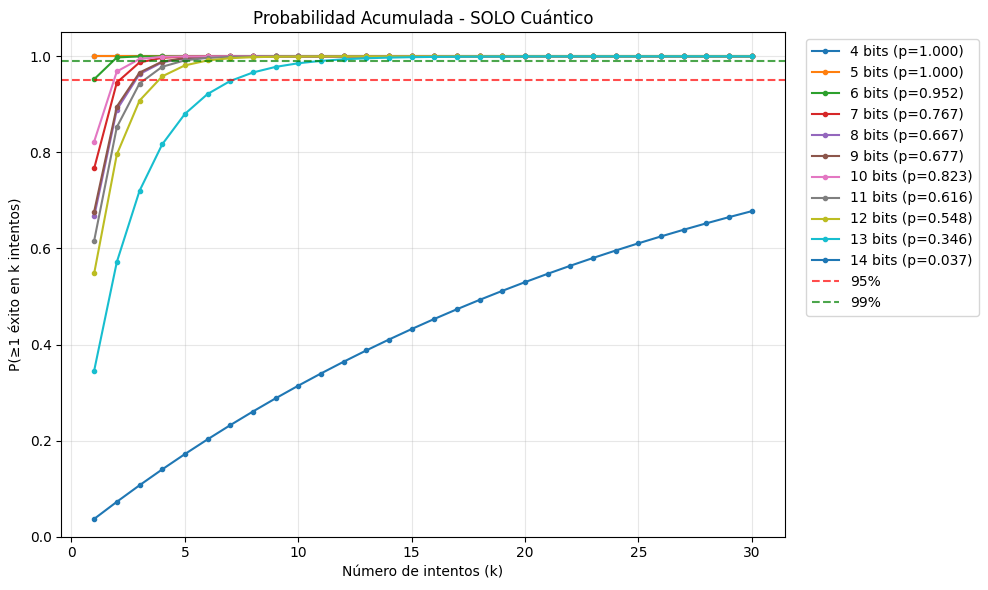

In [41]:
# Gráfica de probabilidad acumulada
def plot_cumulative(df):
    df_q = df[df['method'] != 'gcd_luck']
    
    fig, ax = plt.subplots(figsize=(10, 6))
    k_range = range(1, 31)
    
    for n_bits in sorted(df_q['n_bits'].unique()):
        p = df_q[df_q['n_bits']==n_bits]['success'].mean()
        if p > 0:
            cum = [1 - (1-p)**k for k in k_range]
            ax.plot(k_range, cum, 'o-', markersize=3, label=f'{n_bits} bits (p={p:.3f})')
    
    ax.axhline(0.95, color='r', linestyle='--', alpha=0.7, label='95%')
    ax.axhline(0.99, color='g', linestyle='--', alpha=0.7, label='99%')
    ax.set_xlabel('Número de intentos (k)')
    ax.set_ylabel('P(≥1 éxito en k intentos)')
    ax.set_title('Probabilidad Acumulada - SOLO Cuántico')
    ax.legend(bbox_to_anchor=(1.02, 1))
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.05)
    plt.tight_layout()
    plt.savefig(f"{DATA_DIR}/cumulative_quantum.png", dpi=150)
    plt.show()

plot_cumulative(df)

## Distribuciones: Geométrica vs Gaussiana

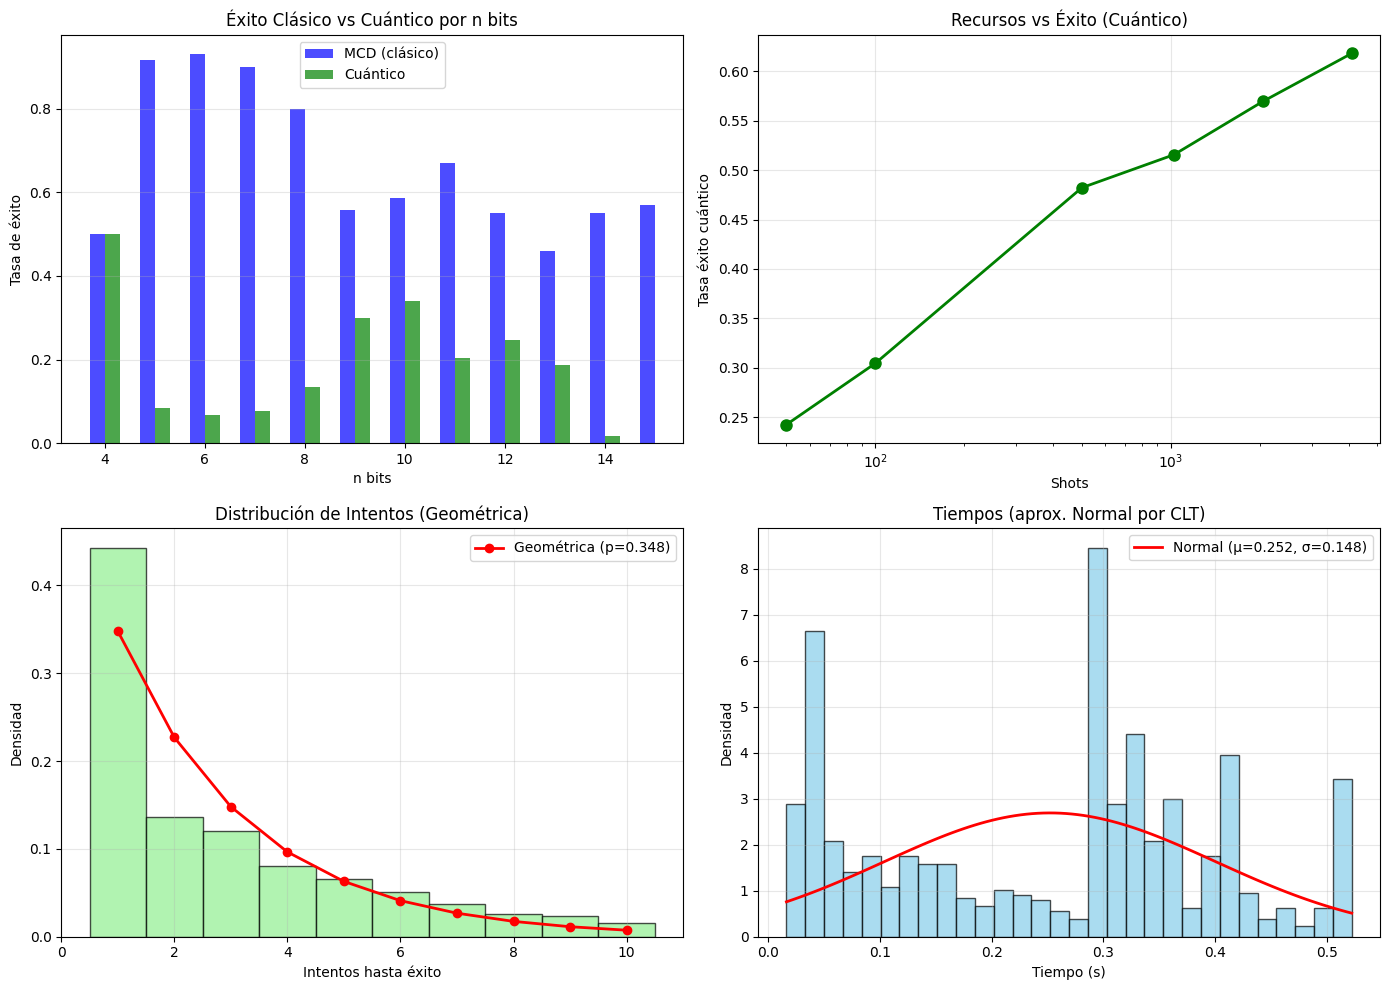

In [42]:
def analyze_distributions(df):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. n bits vs tasa de éxito (separado)
    ax = axes[0, 0]
    by_bits_gcd = df[df['method']=='gcd_luck'].groupby('n_bits').size() / df.groupby('n_bits').size()
    by_bits_q = df[df['method']=='quantum_success'].groupby('n_bits').size() / df.groupby('n_bits').size()
    
    x = sorted(df['n_bits'].unique())
    ax.bar([i-0.15 for i in x], [by_bits_gcd.get(i,0) for i in x], 0.3, label='MCD (clásico)', color='blue', alpha=0.7)
    ax.bar([i+0.15 for i in x], [by_bits_q.get(i,0) for i in x], 0.3, label='Cuántico', color='green', alpha=0.7)
    ax.set_xlabel('n bits')
    ax.set_ylabel('Tasa de éxito')
    ax.set_title('Éxito Clásico vs Cuántico por n bits')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # 2. Shots vs tasa (solo cuántico)
    ax = axes[0, 1]
    df_q = df[df['method'] != 'gcd_luck']
    by_shots = df_q.groupby('M_shots')['success'].mean()
    ax.plot(by_shots.index, by_shots.values, 'go-', linewidth=2, markersize=8)
    ax.set_xlabel('Shots')
    ax.set_ylabel('Tasa éxito cuántico')
    ax.set_title('Recursos vs Éxito (Cuántico)')
    ax.set_xscale('log')
    ax.grid(True, alpha=0.3)
    
    # 3. Distribución de intentos (geométrica)
    ax = axes[1, 0]
    success_df = df_q[df_q['success']==1]
    if len(success_df) > 0:
        attempts = success_df['attempts'].values
        ax.hist(attempts, bins=range(1,12), density=True, alpha=0.7, color='lightgreen', edgecolor='black', align='left')
        
        p_est = 1/attempts.mean() if len(attempts)>0 else 0.5
        x = np.arange(1, 11)
        ax.plot(x, geom.pmf(x, p_est), 'r-o', linewidth=2, label=f'Geométrica (p={p_est:.3f})')
        ax.legend()
    ax.set_xlabel('Intentos hasta éxito')
    ax.set_ylabel('Densidad')
    ax.set_title('Distribución de Intentos (Geométrica)')
    ax.grid(True, alpha=0.3)
    
    # 4. Tiempos (aproximación normal por CLT)
    ax = axes[1, 1]
    times = df_q['time_sec'].values
    times = times[times < np.percentile(times, 99)]
    ax.hist(times, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    mu, std = norm.fit(times)
    x = np.linspace(times.min(), times.max(), 100)
    ax.plot(x, norm.pdf(x, mu, std), 'r-', linewidth=2, label=f'Normal (μ={mu:.3f}, σ={std:.3f})')
    ax.set_xlabel('Tiempo (s)')
    ax.set_ylabel('Densidad')
    ax.set_title('Tiempos (aprox. Normal por CLT)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{DATA_DIR}/distributions_v2.png", dpi=150)
    plt.show()

analyze_distributions(df)

## Límites de Simulación Clásica

In [43]:
def classical_limits():
    print("\n" + "="*70)
    print("LÍMITES DE SIMULACIÓN CUÁNTICA EN PC")
    print("="*70)
    print("\nQubits necesarios para Shor: ~2n + 3")
    print("Memoria: 2^qubits × 16 bytes\n")
    
    for n_bits in [4, 8, 12, 16, 20, 24, 28, 32]:
        qubits = 2*n_bits + 3
        mem_gb = (2**qubits) * 16 / (1024**3)
        status = '✓' if mem_gb < 16 else ('~' if mem_gb < 64 else '✗')
        print(f"  {n_bits:2d} bits → {qubits:2d} qubits → {mem_gb:12.2f} GB {status}")
    
    print("\n" + "-"*70)
    print("Comparación con factorización clásica:")
    print("  128 bits: trivial (microsegundos)")
    print("  512 bits: segundos")
    print(" 1024 bits: minutos")
    print(" 2048 bits: horas (RSA estándar)")
    print("\n   La simulación cuántica está limitada a ~12-14 bits en PCs típicos")
    print("    mientras que clásico factoriza miles de bits sin problema.")

classical_limits()


LÍMITES DE SIMULACIÓN CUÁNTICA EN PC

Qubits necesarios para Shor: ~2n + 3
Memoria: 2^qubits × 16 bytes

   4 bits → 11 qubits →         0.00 GB ✓
   8 bits → 19 qubits →         0.01 GB ✓
  12 bits → 27 qubits →         2.00 GB ✓
  16 bits → 35 qubits →       512.00 GB ✗
  20 bits → 43 qubits →    131072.00 GB ✗
  24 bits → 51 qubits →  33554432.00 GB ✗
  28 bits → 59 qubits → 8589934592.00 GB ✗
  32 bits → 67 qubits → 2199023255552.00 GB ✗

----------------------------------------------------------------------
Comparación con factorización clásica:
  128 bits: trivial (microsegundos)
  512 bits: segundos
 1024 bits: minutos
 2048 bits: horas (RSA estándar)

   La simulación cuántica está limitada a ~12-14 bits en PCs típicos
    mientras que clásico factoriza miles de bits sin problema.


## Resumen Final

In [44]:
def final_summary(df):
    df_q = df[df['method'] != 'gcd_luck']
    
    print("\n" + "="*70)
    print("RESUMEN FINAL DEL EXPERIMENTO")
    print("="*70)
    
    print(f"\n  Datos totales: {len(df)} ejecuciones")
    print(f"   - Éxito por MCD (clásico): {len(df[df['method']=='gcd_luck'])}")
    print(f"   - Éxito cuántico real: {len(df[df['method']=='quantum_success'])}")
    print(f"   - Fracasos: {len(df[df['success']==0])}")
    
    print(f"\n  Métricas cuánticas (excluyendo MCD):")
    print(f"   - Tasa éxito global: {df_q['success'].mean():.4f}")
    print(f"   - Tiempo promedio: {df_q['time_sec'].mean():.4f}s")
    
    print(f"\n  Archivos generados:")
    print(f"   - {DATA_DIR}/shor_experiment_v2.csv")
    print(f"   - {DATA_DIR}/cumulative_quantum.png")
    print(f"   - {DATA_DIR}/distributions_v2.png")
    
    print("\n" + "="*70)
    print("CONCLUSIÓN")
    print("="*70)
    print("El éxito por MCD representa preprocesamiento clásico y disminuye")
    print("con N grandes. El rendimiento cuántico real debe medirse solo")
    print("sobre casos donde gcd(a,N)=1, que es el núcleo del algoritmo.")

final_summary(df)


RESUMEN FINAL DEL EXPERIMENTO

  Datos totales: 3120 ejecuciones
   - Éxito por MCD (clásico): 2057
   - Éxito cuántico real: 506
   - Fracasos: 557

  Métricas cuánticas (excluyendo MCD):
   - Tasa éxito global: 0.4760
   - Tiempo promedio: 0.2555s

  Archivos generados:
   - datasets/shor_experiment_v2.csv
   - datasets/cumulative_quantum.png
   - datasets/distributions_v2.png

CONCLUSIÓN
El éxito por MCD representa preprocesamiento clásico y disminuye
con N grandes. El rendimiento cuántico real debe medirse solo
sobre casos donde gcd(a,N)=1, que es el núcleo del algoritmo.
